In [ ]:
import pandas as pd
import matplotlib.pyplot as plt



Total inquiries: 20337
Unique retailers: 11

Overall score bucket distribution:
  SCORE_BUCKET  inquiries    share_%
0        0–0.2        429   2.109456
1      0.2–0.4       1836   9.027880
2      0.4–0.6       2515  12.366622
3      0.6–0.8       6066  29.827408
4      0.8–0.9       6363  31.287801
5      0.9–1.0       3128  15.380833


/tmp/ipython-input-3085269748.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("SCORE_BUCKET")



Example of retailer summary:
  RETAILER_PARTNER_NUMBER  inquiries  avg_score  median_score  p90_score  \
0                "988431"          8   0.697126      0.660120   0.969717   
1                  124980       1097   0.744726      0.763860   0.894471   
2                  152681        184   0.828094      0.918883   0.987720   
3                  263269       1058   0.896834      0.947483   0.985646   
4                  335569         15   0.872205      0.882849   0.938553   

   max_score  high_score_share  very_high_score_share  high_score_share_%  \
0   0.994435          0.375000               0.375000           37.500000   
1   0.965311          0.386509               0.080219           38.650866   
2   0.996126          0.706522               0.527174           70.652174   
3   0.995906          0.865784               0.710775           86.578450   
4   0.964786          0.866667               0.400000           86.666667   

   very_high_score_share_%  enough_volume  
0     

/tmp/ipython-input-3085269748.py:103: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["RETAILER_PARTNER_NUMBER", "SCORE_BUCKET"])


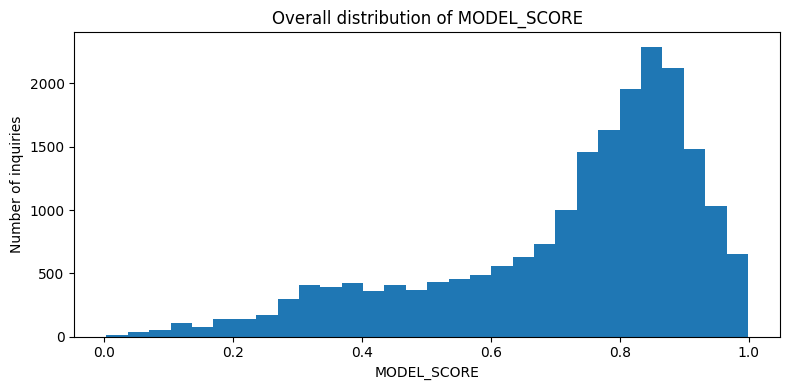

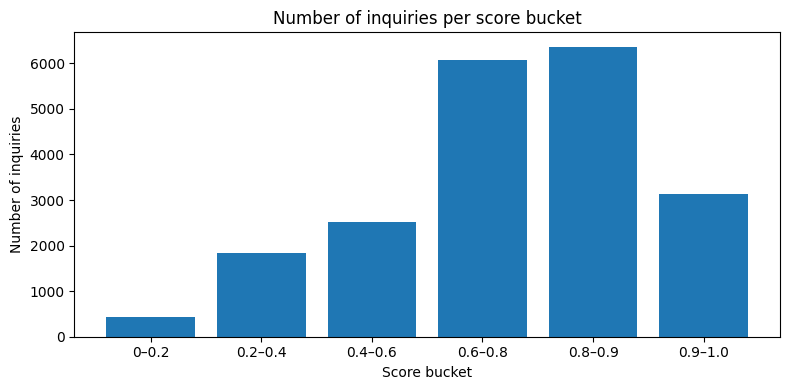

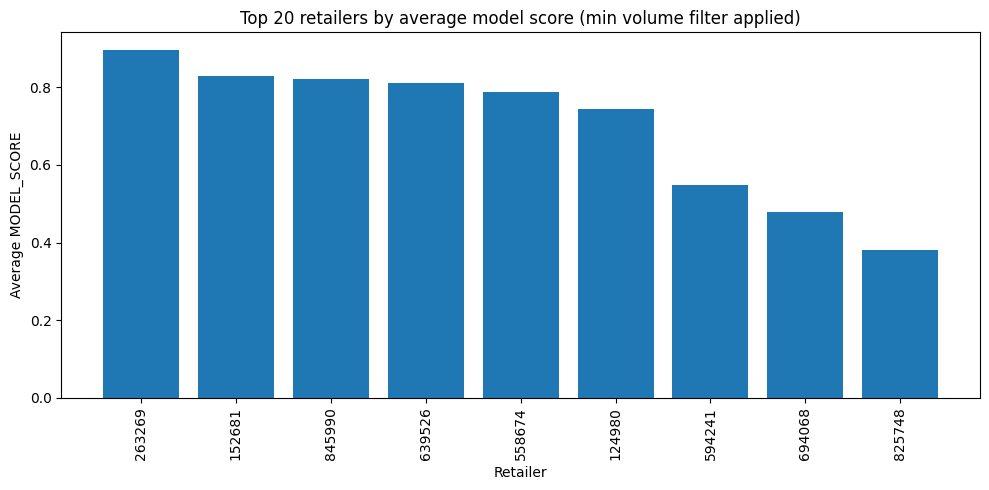

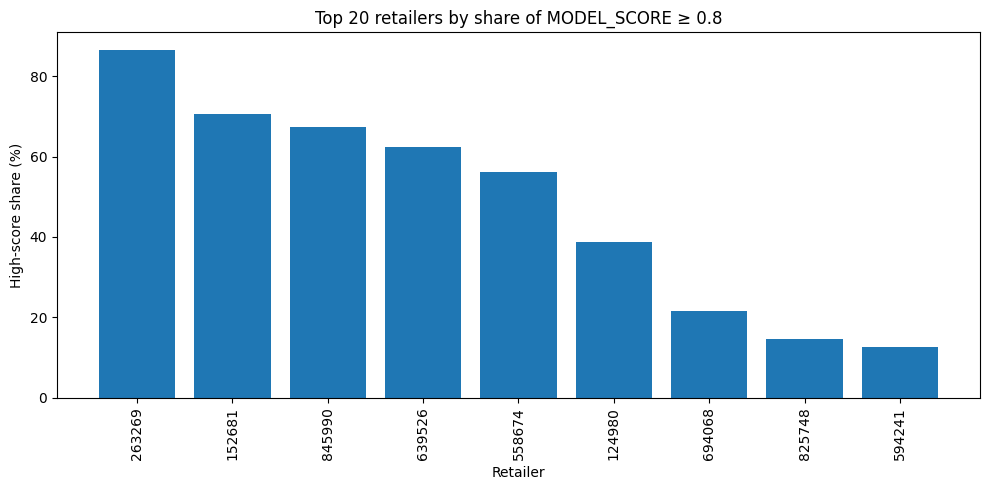


✅ Saved: retailer_ml_score_summary.xlsx
✅ Saved: retailer_ml_score_bucket_breakdown.xlsx


In [ ]:
# -----------------------------
# 1. Load & clean data
# -----------------------------
# Adjust the path / filename as needed
df = pd.read_csv("/content/2025.11 - retailer -  scores - Distri_2025-11-14-1241.csv")

# Standardise column names just in case
df.columns = df.columns.str.upper().str.strip()

# Make sure the key columns exist
required_cols = {
    "INQUIRY_ID",
    "INQUIRY_RECEIVED_AT",
    "MODEL_SCORE",
    "RIR_RULE_LABEL",
    "RETAILER_PARTNER_NUMBER",
}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in file: {missing}")

# Convert types
df["RETAILER_PARTNER_NUMBER"] = df["RETAILER_PARTNER_NUMBER"].astype(str)
df["INQUIRY_RECEIVED_AT"] = pd.to_datetime(df["INQUIRY_RECEIVED_AT"], errors="coerce")
df["MODEL_SCORE"] = pd.to_numeric(df["MODEL_SCORE"], errors="coerce")

# Drop rows with no score
df = df.dropna(subset=["MODEL_SCORE"]).copy()

print(f"Total inquiries: {len(df)}")
print(f"Unique retailers: {df['RETAILER_PARTNER_NUMBER'].nunique()}")


# -----------------------------
# 2. Create score buckets / ranges
# -----------------------------
# Example: you can change the bin edges as you like
bins = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 1.0]
labels = ["0–0.2", "0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–0.9", "0.9–1.0"]

df["SCORE_BUCKET"] = pd.cut(
    df["MODEL_SCORE"],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True,
)

# Overall distribution by bucket
bucket_overview = (
    df.groupby("SCORE_BUCKET")
    .agg(
        inquiries=("INQUIRY_ID", "nunique")
    )
    .reset_index()
)
bucket_overview["share_%"] = (
    bucket_overview["inquiries"] / bucket_overview["inquiries"].sum() * 100
)

print("\nOverall score bucket distribution:")
print(bucket_overview)


# -----------------------------
# 3. Per-retailer metrics
# -----------------------------
# Thresholds for "high" ML scores – tweak if needed
HIGH_THRESHOLD = 0.8
VERY_HIGH_THRESHOLD = 0.9

retailer_summary = (
    df.groupby("RETAILER_PARTNER_NUMBER")
    .agg(
        inquiries=("INQUIRY_ID", "nunique"),
        avg_score=("MODEL_SCORE", "mean"),
        median_score=("MODEL_SCORE", "median"),
        p90_score=("MODEL_SCORE", lambda x: x.quantile(0.9)),
        max_score=("MODEL_SCORE", "max"),
        high_score_share=("MODEL_SCORE", lambda x: (x >= HIGH_THRESHOLD).mean()),
        very_high_score_share=("MODEL_SCORE", lambda x: (x >= VERY_HIGH_THRESHOLD).mean()),
    )
    .reset_index()
)

# Express shares as %
retailer_summary["high_score_share_%"] = retailer_summary["high_score_share"] * 100
retailer_summary["very_high_score_share_%"] = retailer_summary["very_high_score_share"] * 100

# Optional: filter out tiny retailers (few inquiries) to reduce noise
MIN_INQUIRIES = 50   # adjust to your taste
retailer_summary["enough_volume"] = retailer_summary["inquiries"] >= MIN_INQUIRIES

print("\nExample of retailer summary:")
print(retailer_summary.head())


# -----------------------------
# 4. Per-retailer + bucket distribution
# -----------------------------
# Count how many inquiries in each score bucket per retailer
retailer_bucket = (
    df.groupby(["RETAILER_PARTNER_NUMBER", "SCORE_BUCKET"])
    .size()
    .reset_index(name="inquiries")
)

# Add share of each bucket within retailer
retailer_totals = (
    retailer_bucket.groupby("RETAILER_PARTNER_NUMBER")["inquiries"].sum()
    .rename("retailer_total_inquiries")
    .reset_index()
)

retailer_bucket = retailer_bucket.merge(retailer_totals, on="RETAILER_PARTNER_NUMBER")
retailer_bucket["share_within_retailer_%"] = (
    retailer_bucket["inquiries"] / retailer_bucket["retailer_total_inquiries"] * 100
)

print("\nPer-retailer bucket breakdown example:")
print(retailer_bucket.head())


# -----------------------------
# 5. Identify "high-risk" retailers (by ML score)
# -----------------------------
# Example: retailers with enough volume AND high share of score >= 0.8
high_risk_retailers = retailer_summary[
    (retailer_summary["enough_volume"])
    & (retailer_summary["high_score_share"] >= 0.3)  # >= 30% of inquiries high-score
].sort_values("high_score_share", ascending=False)

print("\nRetailers with high share of high ML scores (>= 0.8):")
print(high_risk_retailers.head(20))


# -----------------------------
# 6. Visualisations
# -----------------------------
plt.style.use("default")  # use default style

# 6.1 Overall histogram of model scores
plt.figure(figsize=(8, 4))
plt.hist(df["MODEL_SCORE"], bins=30)
plt.title("Overall distribution of MODEL_SCORE")
plt.xlabel("MODEL_SCORE")
plt.ylabel("Number of inquiries")
plt.tight_layout()
plt.show()

# 6.2 Score bucket distribution (bar chart)
plt.figure(figsize=(8, 4))
plt.bar(bucket_overview["SCORE_BUCKET"].astype(str), bucket_overview["inquiries"])
plt.title("Number of inquiries per score bucket")
plt.xlabel("Score bucket")
plt.ylabel("Number of inquiries")
plt.tight_layout()
plt.show()

# 6.3 Top retailers by average score (with minimum volume)
top_retailers_by_avg = (
    retailer_summary[retailer_summary["enough_volume"]]
    .sort_values("avg_score", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 5))
plt.bar(top_retailers_by_avg["RETAILER_PARTNER_NUMBER"], top_retailers_by_avg["avg_score"])
plt.title("Top 20 retailers by average model score (min volume filter applied)")
plt.xlabel("Retailer")
plt.ylabel("Average MODEL_SCORE")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 6.4 Top retailers by high-score share
top_retailers_by_high_share = (
    retailer_summary[retailer_summary["enough_volume"]]
    .sort_values("high_score_share", ascending=False)
    .head(20)
)

plt.figure(figsize=(10, 5))
plt.bar(
    top_retailers_by_high_share["RETAILER_PARTNER_NUMBER"],
    top_retailers_by_high_share["high_score_share_%"]
)
plt.title(f"Top 20 retailers by share of MODEL_SCORE ≥ {HIGH_THRESHOLD}")
plt.xlabel("Retailer")
plt.ylabel("High-score share (%)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# -----------------------------
# 7. Save outputs
# -----------------------------
retailer_summary.to_excel("retailer_ml_score_summary.xlsx", index=False)
retailer_bucket.to_excel("retailer_ml_score_bucket_breakdown.xlsx", index=False)

print("\n✅ Saved: retailer_ml_score_summary.xlsx")
print("✅ Saved: retailer_ml_score_bucket_breakdown.xlsx")


In [ ]:
# -----------------------------
# 3b. Classify LOW_RISK / NOT_LOW_RISK
# -----------------------------
def classify_low_risk(row):
    return (
        "LOW_RISK"
        if (
            row["enough_volume"] == True
            and row["high_score_share_%"] < 25
            and row["very_high_score_share_%"] < 10
            and row["avg_score"] < 0.70
            and row["median_score"] < 0.60
        )
        else "NOT_LOW_RISK"
    )

retailer_summary["risk_label"] = retailer_summary.apply(classify_low_risk, axis=1)

low_risk_retailers = retailer_summary[retailer_summary["risk_label"] == "LOW_RISK"].copy()

print("\nLow-risk retailers based on ML scores:")
print(low_risk_retailers.head())





Low-risk retailers based on ML scores:
  RETAILER_PARTNER_NUMBER  inquiries  avg_score  median_score  p90_score  \
6                  594241       5238   0.549430      0.532758   0.816803   
9                  825748        940   0.381802      0.268279   0.883594   

   max_score  high_score_share  very_high_score_share  high_score_share_%  \
6   0.974184          0.125048               0.024055           12.504773   
9   0.997056          0.146809               0.087234           14.680851   

   very_high_score_share_%  enough_volume risk_label  
6                 2.405498           True   LOW_RISK  
9                 8.723404           True   LOW_RISK  
